# Studying the orbit of satellite galaxies

This tutorial will help you get started with using galpy to study the orbit of galaxies. In each section, you will see how to use specific galpy functions, and by the end you will have sufficient knowledge to start using galpy. The [galpy documentation](https://docs.galpy.org/en/v1.8.1/index.html) will provide you with further details, if you wish to understand galpy better. The sections below will also provide links to some parts of the documentation, which will give you a general direction to look for more information.

## Outline

There are 4 steps to modelling the orbit of any chosen (satellite) galaxy. They will be the first 4 sections of this tutorial:

1. Initialize an Orbit object
2. Choose a timescale
3. Set up a potential
4. Integrate (and display) the orbit

Then, we also have the following sections. They describe the method to include the LMC affects in the potential, and a few issues that you may encounter:

5. Including the Milky Way centre's barycentric acceleration due to the LMC
6. Forward integration including LMC: Problems to avoid
7. Example: orbit integration of Bootes III
8. A note on the Orbit initialization parameter vo

A brief idea on the 4 steps that cover all about orbit integration:

In essence, we initialize a galpy `Orbit` object to hold all the information about our target galaxy. Then, the orbit integration is done in one line, such as `my_orbit.integrate(ts, potential)`, where `ts` is the timescale that you need to choose, and `potential` holds the potential of the host galaxy—this is where Steps 2 and 3 come into the picture. Afterwards, the result is still in the orbit object that we created, so the last step is just displaying. Now, we will learn the details.

The packages imported below are typically what you need to get started with orbit modelling.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units

from galpy.orbit import Orbit
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.potential.mwpotentials import McMillan17

## 1. Initialize an Orbit object

The first thing that we do is create a galpy `Orbit` object that represents our satellite galaxy. You can either create the object with your own 6D parameters for the galaxy, or you can use a galpy built-in method to get the currently known 6D data. Note that these two methods may create different results, since the 6D data of galaxies may be renewed. (For more details, see the documentation on [Orbit initialization](https://docs.galpy.org/en/v1.8.1/orbit.html#orbit-initialization)).

### 1.1 Manually inputting the 6D data

If you're inputting the initial conditions by hand, be careful of the syntax so that the Orbit object can interpret it correctly. You can use Galactocentric cylindrical coordinates `[R, vR, vT, z, vz, phi]`, or the observed coordinates that we typically use, `[RA, Dec, distance, pmra, pmdec, vlos]`, where the units must be [deg, deg, kpc, mas yr$^{-1}$, mas yr$^{-1}$, km s$^{-1}$], respectively.

All quantities saved in an Orbit object are in galpy's internal units by default, so are the output values. That means if we have integrated the orbit we defined above, the output will not be in physical units. To get outputs in physical units, we can give a few additional arguments when initializing the orbit, so that galpy knows to output in physical units.

The orbit initialization code is simply as follows:

```python
orbit = Orbit([RA, Dec, distance, pmra, pmdec, vlos], ro=8., vo=220.)
```

Here `ro` and `vo` are the distance and velocity scales, $R_0$ and $V_0$. Typically they are just the distance from the Sun to the Milky Way centre, 8 kpc, and the local standard of rest velocity, $V_{LSR}$ = 220 km s$^{-1}$ (There is also something to note about the value 220, although it is just a matter of keeping up to date with literature values. More on this in **Section 8**). 

Alternatively, if the 6D data are in the observed coordinates, we can just use the argument `radec=True`, which also makes the output to be in physical units. This is useful when `ro` and `vo` need not to be changed (because their default values are already in the galpy configuration file), and usually it is a good indicator that your Orbit is consistent in units.

```python
orbit = Orbit([RA, Dec, distance, pmra, pmdec, vlos], radec=True)
```

Given that we usually have these observed coordinates ready at hand, this second line of code is more convenient in most cases.

### 1.2 Using a built-in method

The `Orbit.from_name` method imports the data from the SIMBAD database automatically. The astroquery package needs to be installed in order for SIMBAD to be queried, however galpy does also include a small list of objects saved which can be accessed by using tab completion with `Orbit.from_name('')`. For example, to create an object for the dwarf galaxy Bootes III, we can use this line of code:

```python
orbit = Orbit.from_name("BootesIII")
```

You can also instantiate multiple galaxies at once, by either inputting the 6D data as a multi-dimensional array, or by inputting a list of names (when using the from_name method). 3 collections of objects can also be loaded with from_name: *'MW globular clusters'*, *'MW satellite galaxies'*, and *'solar system'*.

### 1.3 Solar motion
The solar motion is also important for the orbit integration. By default, the solar motion is from Schoenrich et al. (2010), where the solar motion [U,V,W] =[11.1, 12.24, 7.25]. Solar motions already included in galpy are: 'hogg', 'dehnen', 'schoenrich'; but you can also manually choose the solar motion. Note that *galpy uses a left-handed frame*, and so we actually need to enter [-U,V,W], where the U-component is the opposite sign.

An Orbit initialization with everything explicitly defined looks like this:
```python
orbit = Orbit([RA, Dec, distance, pmra, pmdec, vlos], ro=8., vo=220., solarmotion=[-11.1, 12.24, 7.25], 
              radec=True)
```
These values that we entered are the default values that galpy uses. For efficiency, you may choose to omit these arguments except for `radec=True` because it makes the output in physical units.

Further reading: [Orbit initialization from observed coordinates](https://docs.galpy.org/en/v1.8.1/orbit.html#initialization-from-observed-coordinates-or-astropy-skycoord)

### 1.4 Conversion between galpy's natural units and physical units

You can use the `conversion` package to convert between these galpy units and physical units.

Depending on the potential you use, you may need to set the physical conversion factors when instantiating your orbit. For example, if the variable `pot` holds your chosen potential, set `ro = conversion.get_physical(pot)['ro']`, and `vo = conversion.get_physical(pot)['vo']`. Then you can pass `ro` and `vo` along with your 6D data when instantiating the orbit.

Also, if you need outputs to be in the natural galpy coordinates, you can include `o.turn_physical_off()` in your script. You can quickly convert between physical and galpy units by multiplying/dividing by galpy.unit.conversion methods; specific functions can be found in the [galpy docs](https://docs.galpy.org/en/latest/reference/conversion.html).

One thing to keep in mind, however, is that galpy will take care of the units by itself, and we don't necessary need to manually adjust units. As long as we define the first object with physical units (by using `radec=True`), the output will be in physical units (we must also keep the timescale in physical units, namely seconds. The next section is about the timescale). 

## 2. Choose a timescale

Now we have defined our Orbit object, with the variable name `orbit`. To do the orbit integration, all we need is one line of code: `orbit.integrate(ts, potential)`. But we need to know what `ts` and `potential` are, so this section we look at `ts`, the timescale.

The timescale is simply an array of numbers, and throughout our code we will be adjusting this timescale as we see fit. As mentioned earlier, we must also keep the timescale in physical units. The easiest way is to define the array and assign an astropy unit to it.

We have imported `units` from `astropy`, so we make our time array as follows: 

```python
ts = np.linspace(0, 5, 1001) * units.Gyr
```

Using this timescale, we will be integrating the orbit from the current time to 5 Gyr in the future—this is forward integration.

If we want to integration backwards, we just need to use a reversed time array. You can define it as another variable with the numbers counting backwards, but to avoid confusion, you should instead add a minus sign when using the forward timescale. That is, to integrate backwards, we write:

```python
orbit.integrate(-ts, potential)
```

Keep in mind that the further you model from the present, the less accurate the model may become.

## 3. Set up a potential

We have one final variable to create, the `potential`. Typically we import a potential from the galpy potential package, and from our imports at the beginning of this notebook, you can see that we've imported `MWPotential2014`, as well as `McMillan17`. 

The galpy package's default potential is `MWPotential2014`, which is described in detail in Bovy (2015), however it also includes others like McMillan17, from the McMillan (2017) paper, and more. You can also instantiate the potential from scratch, using different potential objects like the MiyamotoNagaiPotential.

### 3.1 Using different potentials

The `MWPotential2014` is the default potential to use, which represents the sum of the halo and disk mass distributions, but does not include the supermassive black hole at the Galactic Centre. The other default parameters such as `ro` and `vo` are also consistent with this potential. So, there is nothing further to change if we are using this potential for the integration. 

The `McMillan17`, however, requires an extra step. We need to use the conversion package to get the appropriate `ro` and `vo` values, and then define our orbit with these values instead of the default ones. For example, if we are integrating the orbit of Bootes III with `McMillan17` as the potential, we need to define the orbit object with the following code:

```python
dist_scale = conversion.get_physical(McMillan17)['ro']
velo_scale = conversion.get_physical(McMillan17)['vo']

orbit = Orbit.from_name('BootesIII', ro=dist_scale, vo=velo_scale)
```

### 3.2 Increasing the halo mass of the potential

In some cases the integrated orbit goes unbound with a given choice of potential. We can fix this problem by *increasing the mass* of the potential. A good way to do so is by making a copy of the original potential and modifying the copy:

```python
MWpot14_doubled = MWPotential2014.copy()
MWpot14_doubled[2] *= 2
```

### 3.3 Including effects of the LMC—the Milky Way's barycentric acceleration

The Large Magellanic Cloud (LMC) is massive enough to have an affect on the Milky Way's potential. Particularly, the Milky Way experiences a reflex motion due to the LMC. We can mimic this effect by adding the LMC as a moving potential to the Milky Way potential that we are using. An orbit integrated with and without this change may result in very different trajectories.

The general steps to do this using galpy is explained [here](https://docs.galpy.org/en/v1.8.1/orbit.html#new-in-v1-8-example-including-the-milky-way-center-s-barycentric-acceleration-due-to-the-large-magellanic-cloud-in-orbit-integrations).

You will find a clear example of this in **Section 5**. Before then, it is good to see the next section on the integration of the orbit, and get a picture of the entire orbit modelling procedure. Afterwards, including the LMC will make more sense.

## 4. Integrate and display the orbit

### 4.1 For a single Orbit object

With the Orbit object named `orbit`, the timescale set up as `ts`, and the potential as `potential`, the orbit can be integrated with one line:

```python
orbit.integrate(ts, potential)
```

You can now plot almost any dynamic property of the orbit, like Galactocentric Cartesian coordinates, cylindrical coordinates, right ascension and declination, etc. You can find the available attributes by either typing `orbit.` and hitting TAB, or by going to the [galpy orbit attributes](https://docs.galpy.org/en/latest/reference/orbit.html#attributes).
Galpy has a method that will plot your coordinates of choice, `orbit.plot(d1, d2)`, where d1 and d2 (string keywords) are the first and second dimensions, or in 3D `orbit.plot(d1, d2, d3)`, or as an animation `orbit.animate(d1, d2)` over the integrated orbit. Galpy plotting methods also allow you to input all of the usual matplotlib arguments. For example, you can change the datapoint colour to black by including `c='k'`. 

You can also always create the plots manually by using `matplotlib.pyplot` methods like so:
```python
plt.plot(orbit.ra(ts), orbit.dec(ts), 'k-')
```
Which would produce a plot of your orbit in the (RA, dec) coordinate space. Here `ts` means we are indexing every element of the resulting values. You can also use only a segment of `ts` to plot a specific part of the orbit, by indexing your values, ex. `o.ra(ts)[:len(ts)/2]` would plot the orbit starting from the current time to half of the timescale. If you don't include `ts` when plotting, only the first value will be plotted and you will just get a single point.

### 4.2 For uncertainties on the orbit, and multiple Orbit objects

In order to include uncertainties from the 6D data when modelling the orbit, the simplest method is to assume that the data can be characterised by a Gaussian distribution. Then, by using numpy or another method, random datapoints can be generated and used in the orbit integration. For example, if you have a 2D array of shape (30,6) named `sixD_unc` (which holds 30 sets of slightly different 6D parameters), then 
```python
orbits = Orbit(sixD_unc, radec=True)
```
will generate a collection of 30 orbits. Then, you can integrate all 30 orbits in the same way you integrate 1 orbit:
```python
orbits.integrate(ts, potential)
```

### 4.3 Retrieving some data from this orbit
As mentioned before, a lot of data is stored in the Orbit object. These can be found in [galpy orbit attributes](https://docs.galpy.org/en/latest/reference/orbit.html#attributes). Some of them aren't very helpful for plotting, but are extremely useful for understanding the orbit. For example,
```python
orbit.rperi()
```
will return a numerically calculated pericentre for the orbit.

Three very useful methods are `rperi()`, `rap()`, and `e()`, which respectively return the pericentre, apocentre, and eccentricity of the orbit.

### 4.4 Pericentre & Apocentre in more detail:
If you're integrating an orbit with a potential that is not an inertial reference frame, **you may sometimes find that your calculated pericentre and apocentre are smaller/larger than expected**. This is because the pericentre and apocentre calculated by galpy to be the minimum and maximum radial distance from the galactic centre, respectively. This problem will arise if your orbit is integrated with more than one orbital period.

One way to get the nearest pericentre & apocentre values without re-integrating the orbit is using scipy and numpy.

**NOTE**: Remember that you want to integrate your orbit backwards when calculating the pericentres & apocentres, so make sure that ts is set up properly for that.

```python
t = 5
ts = np.linspace(0, -t, 1000) # note this is backward timescale

from scipy.signal import argrelextrema
peri_indx = argrelextrema(orbit.r(ts), np.less)[0] # returns indices of local minima
apo_indx = argrelextrema(orbit.r(ts), np.greater)[0] # returns indices of local maxima

peri_nearest = orbit.r(ts)[(peri_indx)[0]]
apo_nearest = orbit.r(ts)[(apo_indx)[0]]
```

`peri_nearest` is the first pericentre in the integrated orbit, while similarily `apo_nearest` is the first apocentre.

## --------------------------------------- Checkpoint ---------------------------------------

At this stage we've described all the basics for getting started with orbit integration. Here is a very quick example before we get on to adding the LMC to our potential.

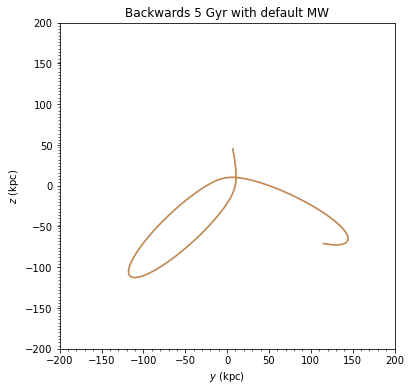

In [2]:
# 6D data of Bootes III (observed coordinates, as mentioned in Section 1)
boo3_6D = [209.3, 26.8, 46.5, -1.16, -0.88, 189.11] 

# Integration timescale (5 Gyr)
ts = np.linspace(0., 5., 1001)*units.Gyr

# Define Orbit object (we define two to verify if they're the same)
orbit1 = Orbit(boo3_6D, ro=8, vo=220, solarmotion=[-11.1, 12.24, 7.25], radec=True)
orbit2 = Orbit(boo3_6D, radec=True)

# *Backward* integration
orbit1.integrate(-ts, MWPotential2014)
orbit2.integrate(-ts, MWPotential2014)

# Plot in the same figure
orbit1.plot(d1='y', d2='z', alpha=0.7)
orbit2.plot(d1='y', d2='z', alpha=0.7, overplot=True)

ax = plt.gca()
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_title('Backwards 5 Gyr with default MW')

fig = plt.gcf()
fig.set_size_inches(6, 6)

This demostrates how to get the orbit integration working. And as we expected, the two orbits we defined are the same, because `orbit1` just has the arguments explicitly written out.

## 5. Including the Milky Way centre's barycentric acceleration due to the LMC

The interaction between the Milky Way halo and the LMC is quite complicated, but for our purpose we just need to do two things: give the potential a non-inertial frame force, and also give it the LMC as a moving potential.

You first need to instantiate the LMC as an Orbit object, and then integrate it backwards along your timescale (assuming you are also integrating your target galaxy backwards. For forward integration, see **Section 6**), assuming that it experiences dynamical friction from the Milky Way. 

Next, you represent the LMC as a moving object potential. We do this by first modelling it as a stationary Hernquist Potential, and then implement its motion by combining this potential with its integrated orbit. It can then be added to the potential of the Milky Way.

Depending on the location of your satellite galaxy, the Milky Way's barycentric acceleration may not affect your orbit drastically, but it will still produce a more accurate result. We start by defining the functions that give the origin acceleration, in rectangular coordinates. The functions are then interpolated to speed up the numerical calculations of the NonInertialFrameForce.

The code below is taken from this section of the [documentation](https://docs.galpy.org/en/v1.8.1/orbit.html#new-in-v1-8-example-including-the-milky-way-center-s-barycentric-acceleration-due-to-the-large-magellanic-cloud-in-orbit-integrations).

In [ ]:
# Define the LMC orbit object
orbit_LMC = Orbit.from_name('LMC')

# Define dynamical friction force
cdf = ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun, rhm=5.*units.kpc, dens=MWPotential2014)

# Integrate the LMC orbit with the dynamical friction
ts = np.linspace(0., 10., 1001)*units.Gyr
orbit_LMC.integrate(-ts, MWPotential2014 + cdf) # note this is backward ts

# Set it as moving object potential
lmcpot = HernquistPotential(amp=2*10.**11.*units.Msun, a=5.*units.kpc/(1.+np.sqrt(2.))) #rhm = (1+sqrt(2)) a
moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot)

# Acceleration at origin
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

# Use interpolation function to speed things up
t_intunits= orbit_LMC.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int = np.array([ax(t) for t in t_intunits])
ax_int = lambda t : np.interp(t, t_intunits, ax4int)
ay4int = np.array([ay(t) for t in t_intunits])
ay_int = lambda t : np.interp(t, t_intunits, ay4int)
az4int = np.array([az(t) for t in t_intunits])
az_int = lambda t : np.interp(t, t_intunits, az4int)

nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

total_potential = MWPotential2014 + nip + moving_lmcpot

This `total_potential` is now the potential to use in the orbit integration.

**Note**: in the code above, we have set up the LMC potential to be backwards 10 Gyr. Also, the interpolation time is written as `t_intunits= o.time(use_physical=False)[::-1]`, which is also a reversed time array. This `total_potential` can only be used for backward integration.

**If you are using McMillan17, when defining** `ChandrasekharDynamicalFrictionForce` **, enter** `dens=McMillan17[1]` **with the extra indexing. This is just the way McMillan17 is defined.**

## 6. Forward integration including LMC: Problems to avoid

Just before the end of the last section, we've emphasized that the potential we set up is only valid for backward integration. For forward integration, you must remember to make two adjustments to the code above, so that the everything is consistent with a forward timescale.

### 6.1 The changes needed for forward integration with LMC

First, when we integrate the orbit of LMC, we must use the forward timescale. As mentioned earlier, we want to reduce the chances of making mistakes by keeping the timescale "forward", and for "backward" use we just add the minus sign. So, here we just remove the minus sign.
```python
ts = np.linspace(0., 10., 1001)*units.Gyr
orbit_LMC.integrate(ts, MWPotential2014 + cdf)
```

Then, most importantly, when we do acceleration interpolation to get the NonInertialFrameForce `nip`, we also need to change the line 
```python
t_intunits= o_lmc.time(use_physical=False)[::-1] # need to reverse the order for interp
```
to
```python
t_intunits= o_lmc.time(use_physical=False)
```
Now we can integrate forward and expect the result to be logically correct.

### 6.2 Possible error you may find

Any time you lost track of your timescale variables or you forgot to "flip" a time array, the resulting orbit may become unbound when integrating forward. When that happens, the best thing to do is to check carefully of all your variables, because that's the most common cause of the error. The two lines of code mentioned above must be changed appropriately.

You may also find that even with the "settings" correct, the orbit still goes unbound. This is also explained [here](https://docs.galpy.org/en/v1.8.1/orbit.html#example-the-orbit-of-the-large-magellanic-cloud-in-the-presence-of-dynamical-friction). The cause is most likely that the Milky Way halo mass is not large enough to keep the LMC bound, and that causes the orbit of your target galaxy to go unbound as well. The solution to this problem is to increase the halo mass, and the method to do so is mentioned in **Section 3.2**.

## 7. Example: orbit integration of Bootes III

Now we will show a walkthrough of generating the orbit for Bootes III, with two different Milky Way potentials, and also with LMC.

In [3]:
# A reminder of the functions we imported

import numpy as np
import matplotlib.pyplot as plt
from astropy import units

from galpy.orbit import Orbit
from galpy.util import conversion
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.potential.mwpotentials import McMillan17

In [4]:
# 6D data of Bootes III (observed coordinates, as mentioned in Section 1)
boo3_6D = [209.3, 26.8, 46.5, -1.16, -0.88, 189.11]

# Timescale
ts = np.linspace(0., 5., 1001)*units.Gyr

### 7.1 Using MWPotential2014 and McMillan17 without LMC

In [5]:
# This is for MWPotential2014
orbit1_forward = Orbit(boo3_6D, radec=True)
orbit1_backward = Orbit(boo3_6D, radec=True)

In [6]:
# This is for McMillan17
dist_scale = conversion.get_physical(McMillan17)['ro']
velo_scale = conversion.get_physical(McMillan17)['vo']

orbit2_forward = Orbit(boo3_6D, ro=dist_scale, vo=velo_scale, radec=True)
orbit2_backward = Orbit(boo3_6D, ro=dist_scale, vo=velo_scale, radec=True)

In [7]:
# Forward
orbit1_forward.integrate(ts, MWPotential2014)
orbit2_forward.integrate(ts, McMillan17)

# Backward
orbit1_backward.integrate(-ts, MWPotential2014)
orbit2_backward.integrate(-ts, McMillan17)

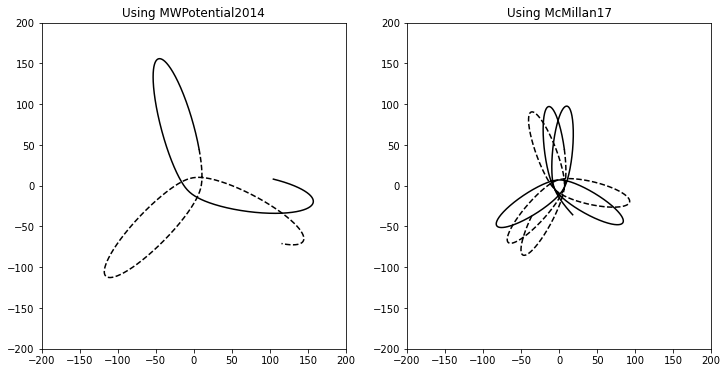

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(orbit1_forward.y(ts), orbit1_forward.z(ts), c='k')
ax[0].plot(orbit1_backward.y(-ts), orbit1_backward.z(-ts), c='k', ls='--')
ax[0].set_xlim(-200, 200)
ax[0].set_ylim(-200, 200)
ax[0].set_title('Using MWPotential2014')

ax[1].plot(orbit2_forward.y(ts), orbit2_forward.z(ts), c='k')
ax[1].plot(orbit2_backward.y(-ts), orbit2_backward.z(-ts), c='k', ls='--')
ax[1].set_xlim(-200, 200)
ax[1].set_ylim(-200, 200)
ax[1].set_title('Using McMillan17')

plt.show()

### 7.2 Using MWPotential2014 including LMC

Creating a custom function to "build" the potential for us will be a good option, so that we don't mix the forward and backward variables.

In [9]:
def get_total_potential(forward=False):
    """Only for adding the LMC to MWPotential2014.
    """
    orbit_LMC = Orbit.from_name('LMC')

    cdf = ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun, rhm=5.*units.kpc, dens=MWPotential2014)

    if forward:
        orbit_LMC.integrate(ts, MWPotential2014 + cdf)
    else:
        orbit_LMC.integrate(-ts, MWPotential2014 + cdf)
        
    lmcpot = HernquistPotential(amp=2*10.**11.*units.Msun, a=5.*units.kpc/(1.+np.sqrt(2.)))
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot)

    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return MWPotential2014 + nip + moving_lmcpot

In [10]:
potential_backward = get_total_potential()
potential_forward = get_total_potential(forward=True)

In [11]:
orbit1_forward = Orbit(boo3_6D, radec=True)
orbit1_backward = Orbit(boo3_6D, radec=True)

orbit1_forward.integrate(ts, potential_forward)
orbit1_backward.integrate(-ts, potential_backward)

### 7.3 Using McMillan17 including LMC

We will show plots after doing the same for McMillan17. For McMillan17, notice the use of `ro` and `vo`. Also notice syntax `dens=McMillan17[1]`.

In [12]:
def get_total_potential2(forward=False):
    """Only for adding the LMC to McMillan17.
    """
    ro = conversion.get_physical(McMillan17)['ro']
    vo = conversion.get_physical(McMillan17)['vo']
    
    orbit_LMC = Orbit.from_name('LMC', ro=ro, vo=vo)

    cdf = ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun, rhm=5.*units.kpc, dens=McMillan17[1],
                                             ro=ro, vo=vo)

    if forward:
        orbit_LMC.integrate(ts, McMillan17 + cdf)
    else:
        orbit_LMC.integrate(-ts, McMillan17 + cdf)
        
    lmcpot = HernquistPotential(amp=2*10.**11.*units.Msun, a=5.*units.kpc/(1.+np.sqrt(2.)), 
                                ro=ro, vo=vo)
    moving_lmcpot = MovingObjectPotential(orbit_LMC, pot=lmcpot, 
                                          ro=ro, vo=vo)

    loc_origin= 1e-4 # Small offset in R to avoid numerical issues
    ax = lambda t : evaluateRforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)
    ay = lambda t : evaluatephitorques(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False) / loc_origin
    az = lambda t : evaluatezforces(moving_lmcpot, loc_origin, 0., phi=0., t=t, use_physical=False)

    if forward:
        t_intunits= orbit_LMC.time(use_physical=False)
    else:
        t_intunits= orbit_LMC.time(use_physical=False)[::-1]

    ax4int = np.array([ax(t) for t in t_intunits])
    ax_int = lambda t : np.interp(t, t_intunits, ax4int)
    ay4int = np.array([ay(t) for t in t_intunits])
    ay_int = lambda t : np.interp(t, t_intunits, ay4int)
    az4int = np.array([az(t) for t in t_intunits])
    az_int = lambda t : np.interp(t, t_intunits, az4int)

    nip = NonInertialFrameForce(a0=[ax_int, ay_int, az_int])

    return McMillan17 + nip + moving_lmcpot

In [13]:
potential_backward = get_total_potential2()
potential_forward = get_total_potential2(forward=True)

In [14]:
# This is for McMillan17
ro = conversion.get_physical(McMillan17)['ro']
vo = conversion.get_physical(McMillan17)['vo']

orbit2_forward = Orbit(boo3_6D, ro=ro, vo=vo, radec=True)
orbit2_backward = Orbit(boo3_6D, ro=ro, vo=vo, radec=True)

orbit2_forward.integrate(ts, potential_forward)
orbit2_backward.integrate(-ts, potential_backward)

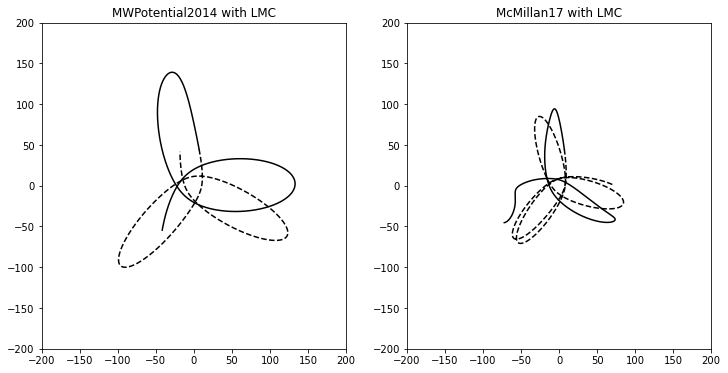

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(orbit1_forward.y(ts), orbit1_forward.z(ts), c='k')
ax[0].plot(orbit1_backward.y(-ts), orbit1_backward.z(-ts), c='k', ls='--')
ax[0].set_xlim(-200, 200)
ax[0].set_ylim(-200, 200)
ax[0].set_title('MWPotential2014 with LMC')

ax[1].plot(orbit2_forward.y(ts[:len(ts)//2]), orbit2_forward.z(ts[:len(ts)//2]), c='k')
ax[1].plot(orbit2_backward.y(-ts), orbit2_backward.z(-ts), c='k', ls='--')
ax[1].set_xlim(-200, 200)
ax[1].set_ylim(-200, 200)
ax[1].set_title('McMillan17 with LMC')

plt.show()

(For McMillan17, the later half of the forward integrated orbit becomes unphysical so it is cut out.)

### 7.4 Uncertainty

Here is our 6D parameters:

In [16]:
boo3_6D

[209.3, 26.8, 46.5, -1.16, -0.88, 189.11]

We have some uncertainties for the distance, proper motion, and velocity. Let's make 1000 orbits assuming the error is normally distributed.

In [17]:
unc_list = [0, 0, 2.0, 0.02, 0.01, 1.56]

boo3_6D_unc = np.random.normal(loc=boo3_6D, scale=unc_list, size=(1000, 6))

In [18]:
orbits_forward = Orbit(boo3_6D_unc, radec=True)
orbits_backward = Orbit(boo3_6D_unc, radec=True)

potential_backward = get_total_potential()
potential_forward = get_total_potential(forward=True)

orbits_forward.integrate(ts, potential_forward)
orbits_backward.integrate(-ts, potential_backward)

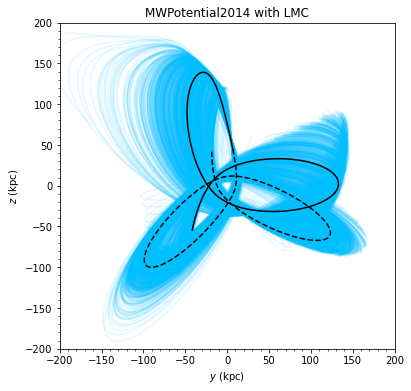

In [22]:
orbits_backward.plot(d1='y', d2='z', c='deepskyblue', alpha=0.1)
orbits_forward.plot(d1='y', d2='z', c='deepskyblue', alpha=0.1, overplot=True)
orbit1_backward.plot(d1='y', d2='z', c='k', ls='--', overplot=True)
orbit1_forward.plot(d1='y', d2='z', c='k', overplot=True)

ax = plt.gca()
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_title('MWPotential2014 with LMC')

fig = plt.gcf()
fig.set_size_inches(6, 6)

## 8. A note on the parameter `vo`

As you have read above, `ro` and `vo` are the distance and velocity scales for our orbit. The internal units of galpy will be scaled to physical units with these values. By default, `ro = 8` kpc and `vo = 220` km/s, which are also used in converting celestial (heliocentric) coordinates to Galactocentric coordinates when we calculate the orbit.

The value `vo` corresponds to the local standard of rest (LSR) velocity and in [Equation (3) of this article](https://iopscience.iop.org/article/10.3847/2515-5172/aaef8b) we have that $V_\mathrm{LSR} = 233.4$ km/s. When we convert coordinates it's the total rotation speed that matters ($V_\odot + V_\mathrm{LSR}$). The $V_\odot$ value is the V-component of the solar motion that we specify when initializing an Orbit. 

This difference of about 13 km/s in the `vo` value is not significant to orbit integration. However, when we need to do stream simulation and we are generating stream particles, there is a very noticeable affect in changing this value. 

The takeaway is that we need to look out for any updated numbers in the literature. You may want to manually specify `vo = 233.4` when initializing an orbit. Alternatively, you could modify the configuration file and change the default of `vo` to this new value.